# Map between two states and get free energy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.7

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.7


In [20]:
import jax
import equinox as eqx
import logging
import git
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
from dataclasses import asdict
from typing import cast

from rigid_flows.data import DataWithAuxiliary
from rigid_flows.density import KeyArray, OpenMMDensity
from rigid_flows.flow import (
    RigidWithAuxiliary,
    build_flow,
    initialize_actnorm,
    toggle_layer_stack,
)
from rigid_flows.reporting import Reporter, pretty_json
from rigid_flows.specs import ExperimentSpecification
from rigid_flows.train import run_training_stage

from flox._src.flow.api import Transform
from flox._src.flow.sampling import PushforwardSampler, PullbackSampler
from flox.flow import Pipe
from flox.util import key_chain


In [4]:
def setup_model(key: KeyArray, specs: ExperimentSpecification):
    chain = key_chain(key)

    print("Loading base density.")
    base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base)

    print(f"Loading target density.")
    target = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.target)

    print(f"Setting up flow model.")
    flow = build_flow(
        next(chain),
        specs.model.auxiliary_shape,
        specs.model.flow,
        base,
        # target,
    )

    print(f"Initializing ActNorm")

    @eqx.filter_jit
    def init_actnorm(flow, key):
        actnorm_batch = jax.vmap(target.sample)(
            jax.random.split(key, specs.act_norm_init_samples)
        ).obj
        flow = toggle_layer_stack(flow, False)
        flow, _ = initialize_actnorm(flow, actnorm_batch)
        flow = toggle_layer_stack(flow, True)
        return flow

    flow = init_actnorm(flow, next(chain))

    if specs.model.pretrained_model_path is not None:
        print(f"Loading pre-trained model from {specs.model.pretrained_model_path}.")
        flow = cast(
            Pipe[DataWithAuxiliary, RigidWithAuxiliary],
            eqx.tree_deserialise_leaves(specs.model.pretrained_model_path, flow),
        )

    return base, target, flow


def train(
    key: KeyArray,
    run_dir: str,
    specs: ExperimentSpecification,
    base: OpenMMDensity,
    target: OpenMMDensity,
    flow: Transform[DataWithAuxiliary, DataWithAuxiliary],
    tot_iter: int,
    loss_reporter: list,
) -> Transform[DataWithAuxiliary, DataWithAuxiliary]:
    chain = key_chain(key)
    # repo = git.Repo(search_parent_directories=True)
    # branch = repo.active_branch.name
    # sha = repo.head.object.hexsha

    # log = asdict(specs)
    # log["git"] = {"branch": branch, "sha": sha}
    # tf.summary.text("run_params", pretty_json(log), step=tot_iter)
    print(f"Starting training.")
    reporter = Reporter(
        base,
        target,
        run_dir,
        specs.reporting,
        scope=None,
    )
    reporter.with_scope(f"initial").report_model(next(chain), flow, tot_iter)
    for stage, train_spec in enumerate(specs.train):
        flow = run_training_stage(
            next(chain),
            base,
            target,
            flow,
            train_spec,
            specs.model.target,
            reporter.with_scope(f"training_stage_{stage}"),
            tot_iter,
            loss_reporter,
        )
        tot_iter += train_spec.num_iterations
    return flow


In [5]:
specs_file = "testing.yaml"
specs = ExperimentSpecification.load_from_file(specs_file)

chain = key_chain(specs.seed)

base, target, flow = setup_model(next(chain), specs)

model = base.omm_model.model

tot_iter = specs.global_step if specs.global_step is not None else 0


Loading base density.
Loading target density.
Setting up flow model.
Initializing ActNorm


In [6]:
num_samples = 1_000
keys = jax.random.split(next(chain), num_samples)

base_obj = jax.vmap(base.sample)(keys).obj
pos = base_obj.pos.reshape(-1, model.n_atoms, 3)


In [7]:
# model.plot_2Dview(pos)
# model.get_view(pos)


In [8]:
# for i in range(3):
#     # plt.plot(pos[:,model.n_sites * 3, i]-np.mean(pos, axis=1)[:,i]+model.box[i,i]/2, '.')
#     plt.plot(pos[:,model.n_sites * 3, i], '.')
#     plt.plot(np.mean(pos, axis=1)[:,i], '.')
#     plt.axhline(model.box[i,i]/2, c='k', ls=':')
#     plt.ylim(0, model.box[i,i])
#     plt.xlim(0, len(pos))
#     plt.show()


In [9]:
keys = jax.random.split(next(chain), num_samples)
target_obj = jax.vmap(target.sample)(keys).obj


In [10]:
from rigid_flows.flow import to_rigid

k = 10
base_k_oxy = jax.vmap(to_rigid)(base_obj.pos[:, k]).obj
target_k_oxy = jax.vmap(to_rigid)(target_obj.pos[:, k]).obj


In [11]:
keys = jax.random.split(next(chain), num_samples)
bg_obj = jax.vmap(PullbackSampler(base.sample, flow))(keys).obj
bg_k_oxy = jax.vmap(to_rigid)(bg_obj.pos[:, k]).obj


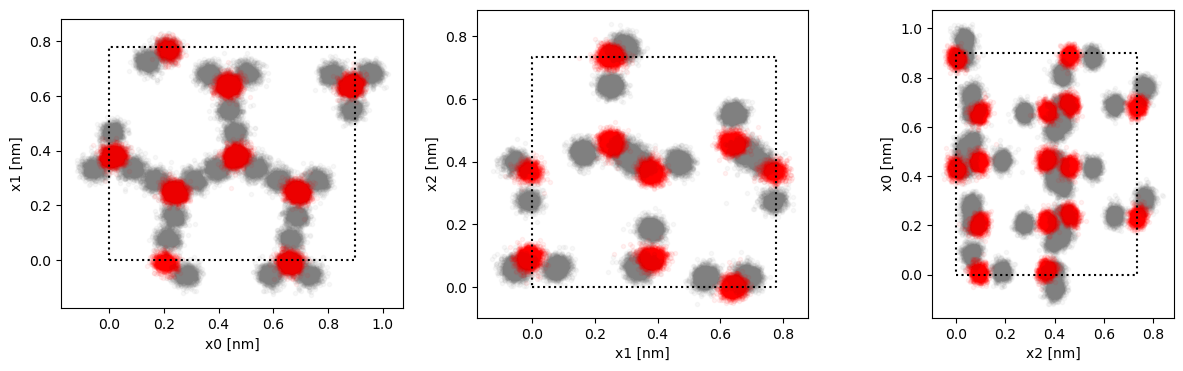

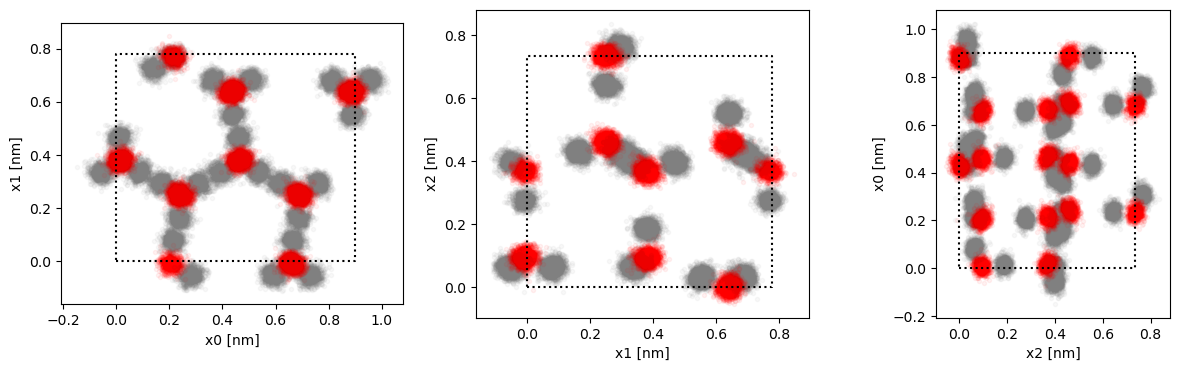

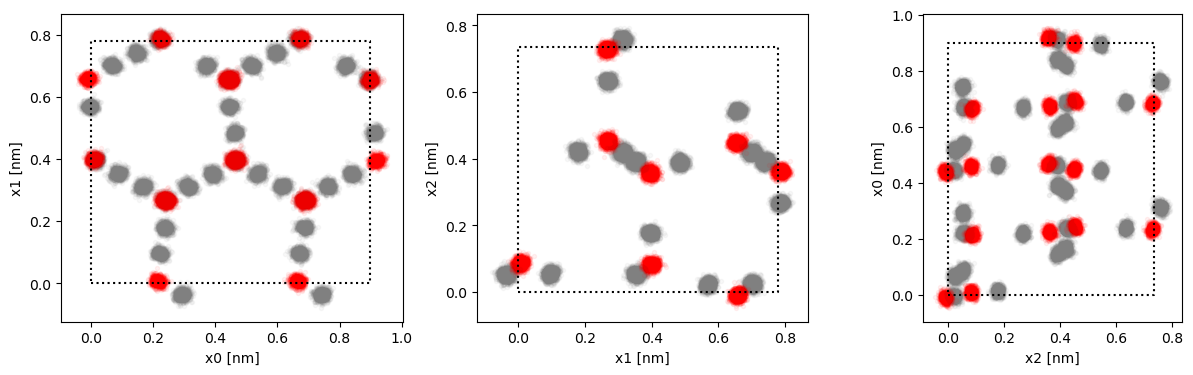

In [12]:
model.plot_2Dview(base_obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(bg_obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(target_obj.pos.reshape(-1, model.n_atoms, 3))


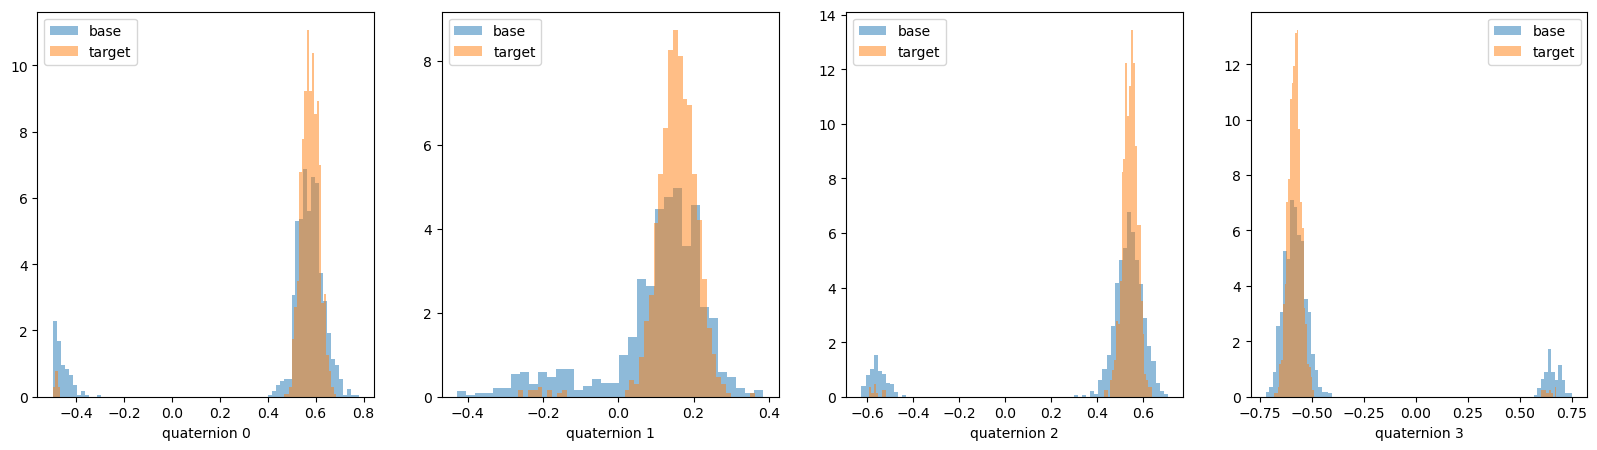

In [13]:
hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    plt.hist(base_k_oxy.rot[:, i], **hist_kwargs, label="base")
    plt.hist(target_k_oxy.rot[:, i], **hist_kwargs, label="target")
    plt.xlabel(f"quaternion {i}")
    plt.legend()
plt.show()


In [14]:
def normalize_quats(quats, ref):
    sign = np.sign(np.sum(quats * ref[None], axis=-1, keepdims=True))
    quats = quats * sign
    return quats


unsigned_base = normalize_quats(base_k_oxy.rot, base_k_oxy.rot[0])
unsigned_target = normalize_quats(target_k_oxy.rot, target_k_oxy.rot[0])


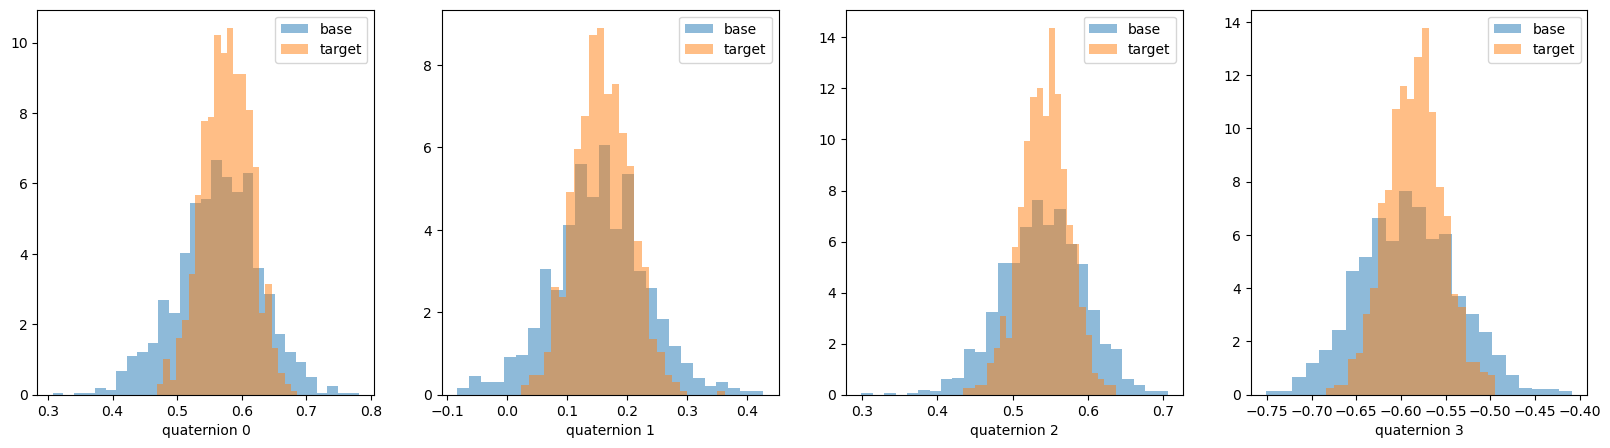

In [15]:
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    plt.hist(unsigned_base[:, i], **hist_kwargs, label="base")
    plt.hist(unsigned_target[:, i], **hist_kwargs, label="target")
    plt.xlabel(f"quaternion {i}")
    plt.legend()
plt.show()


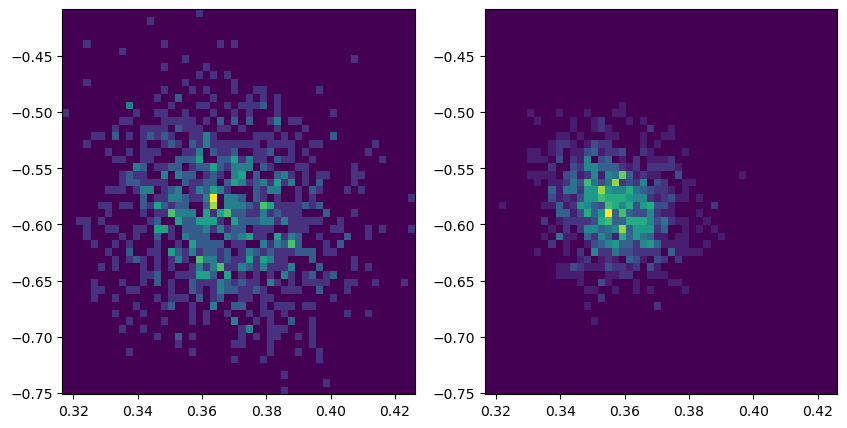

In [16]:
i = 2
j = 3
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
_, xbins, ybins, _ = plt.hist2d(base_k_oxy.pos[:, i], unsigned_base[:, j], bins=50)
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.subplot(1, 2, 2)
plt.hist2d(target_k_oxy.pos[:, i], unsigned_target[:, j], bins=(xbins, ybins))
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.show()


Starting training.


Epoch: 3/3: 100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s, loss=-641.8417]
/srv/data/minvernizzi/notebook/water/rigid-flows/rigid_flows/reporting.py:239: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<Figure size 640x480 with 0 Axes>

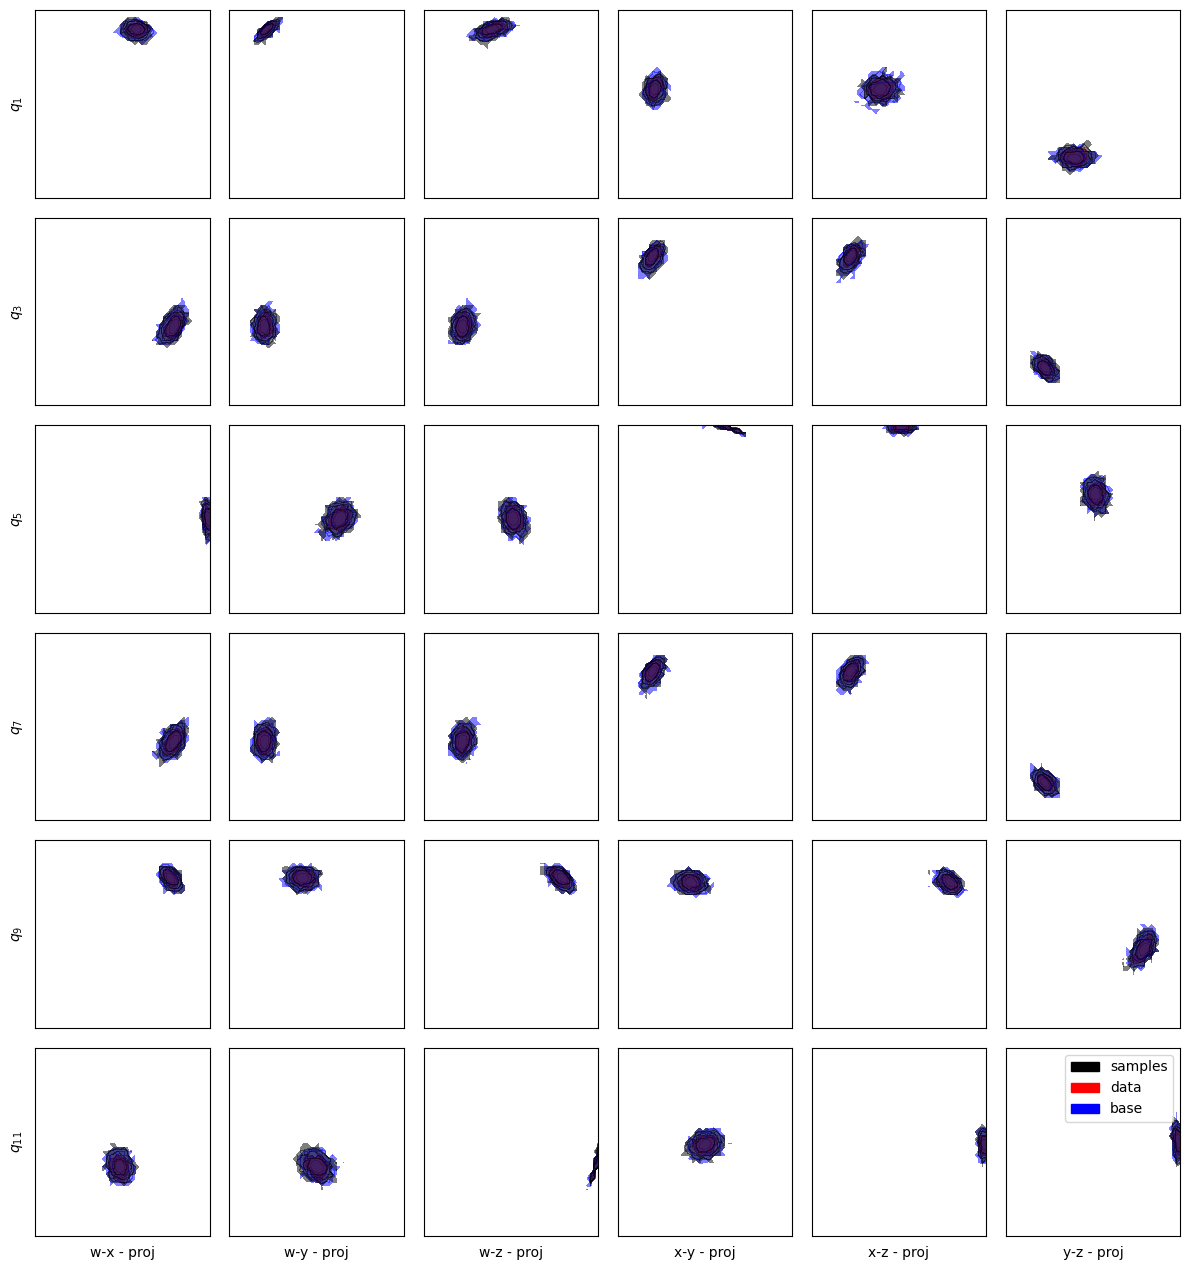

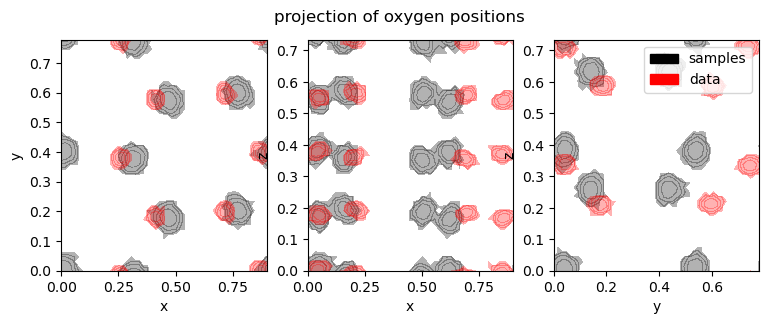

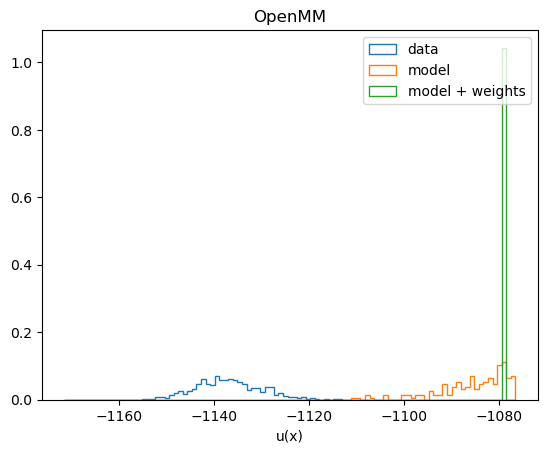

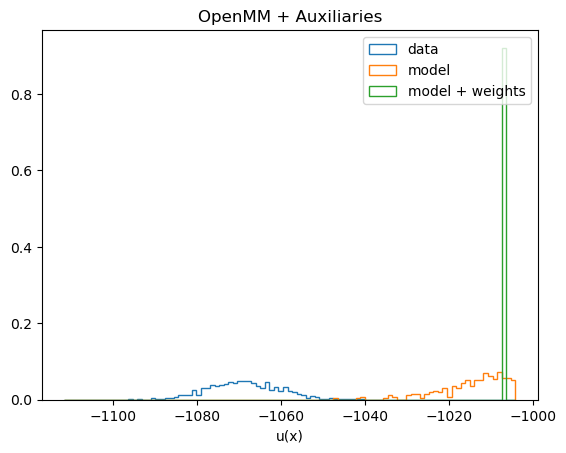

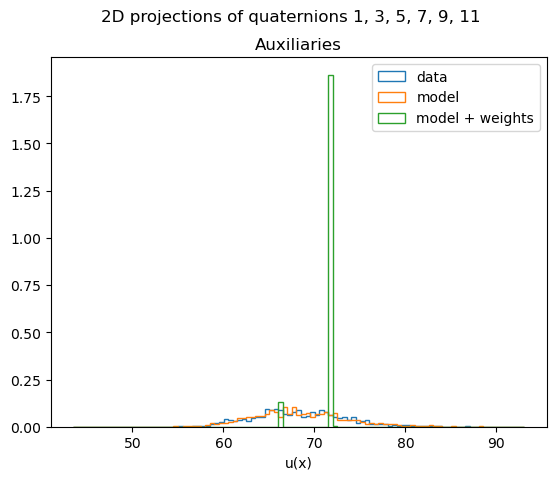

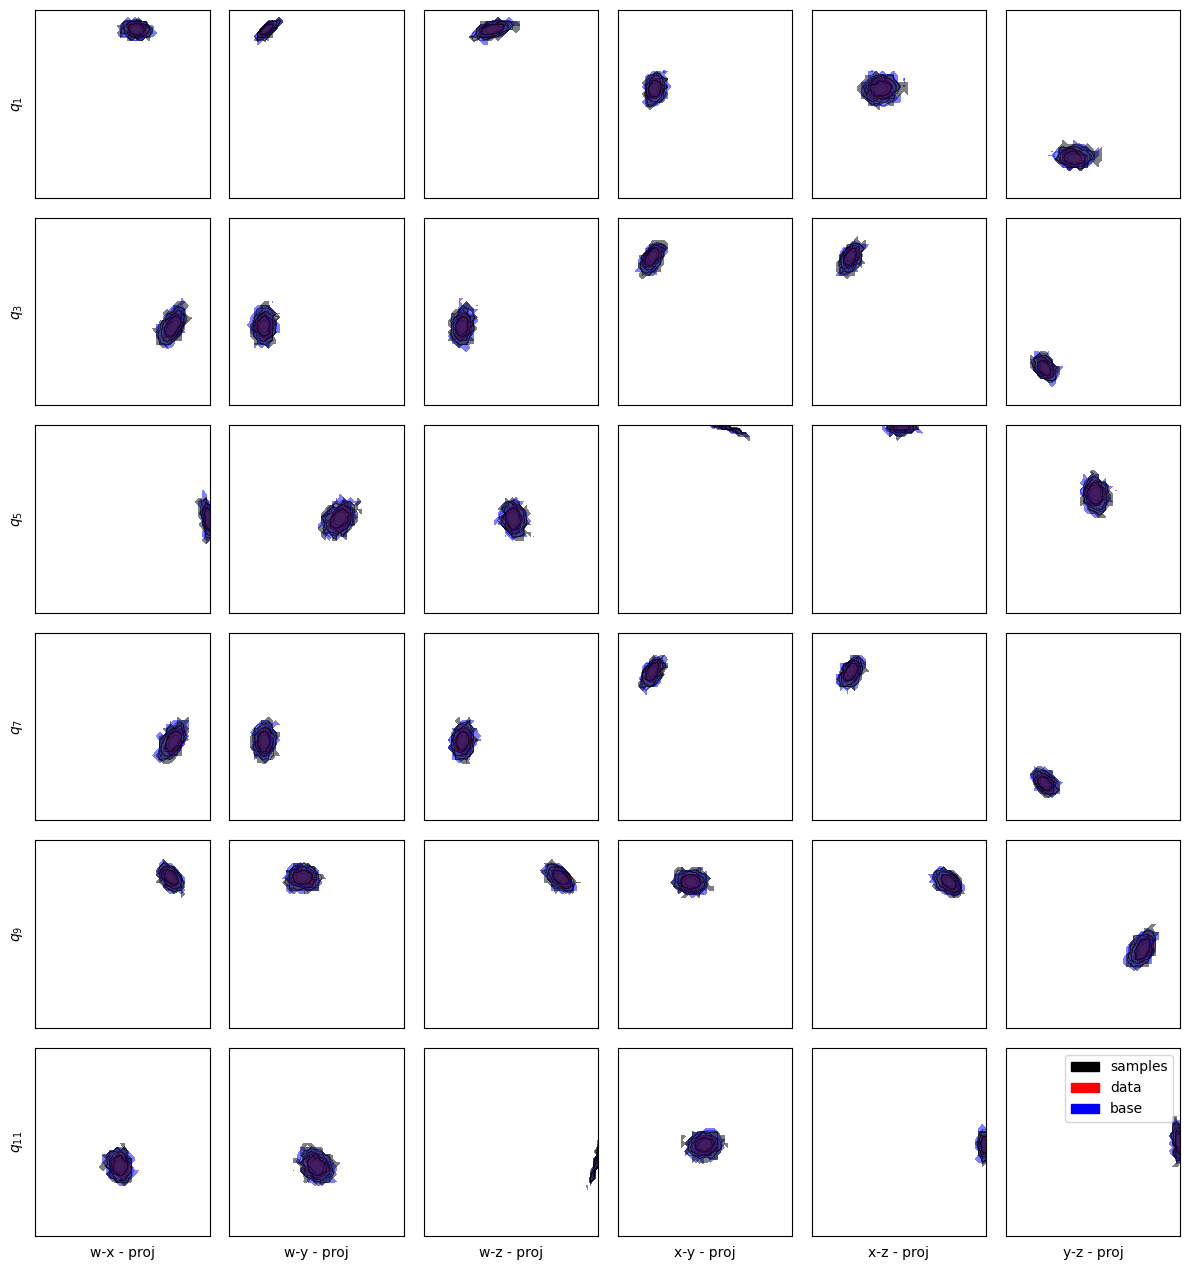

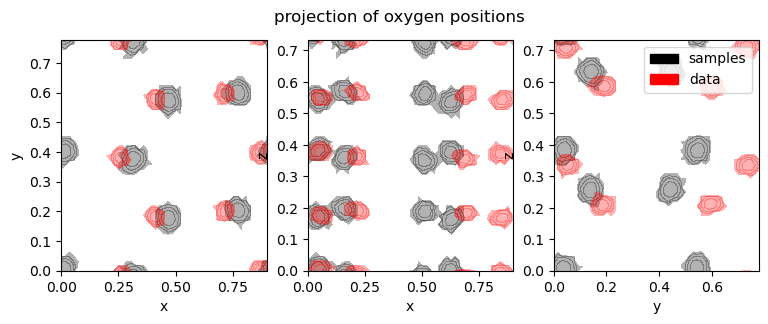

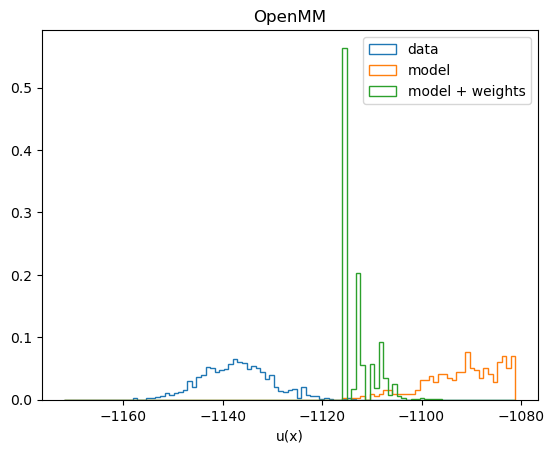

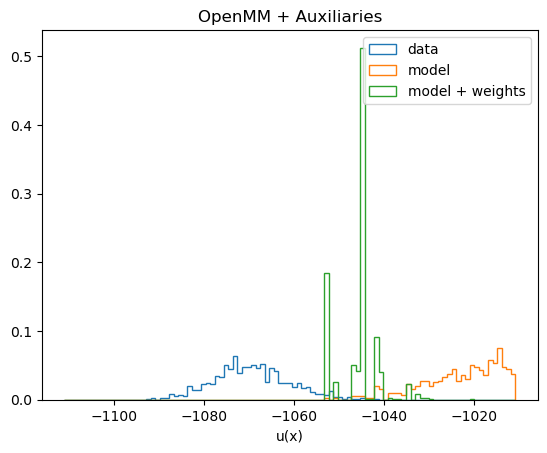

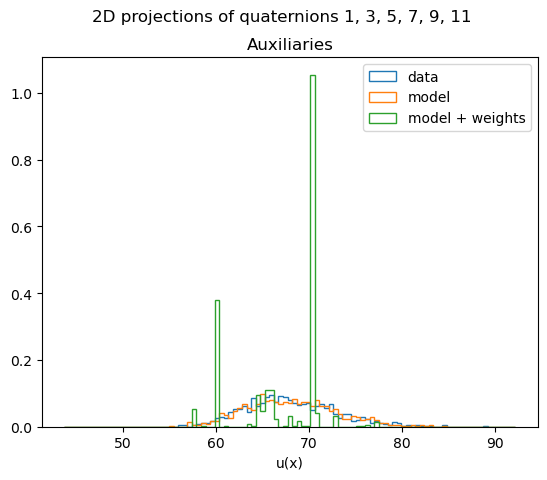

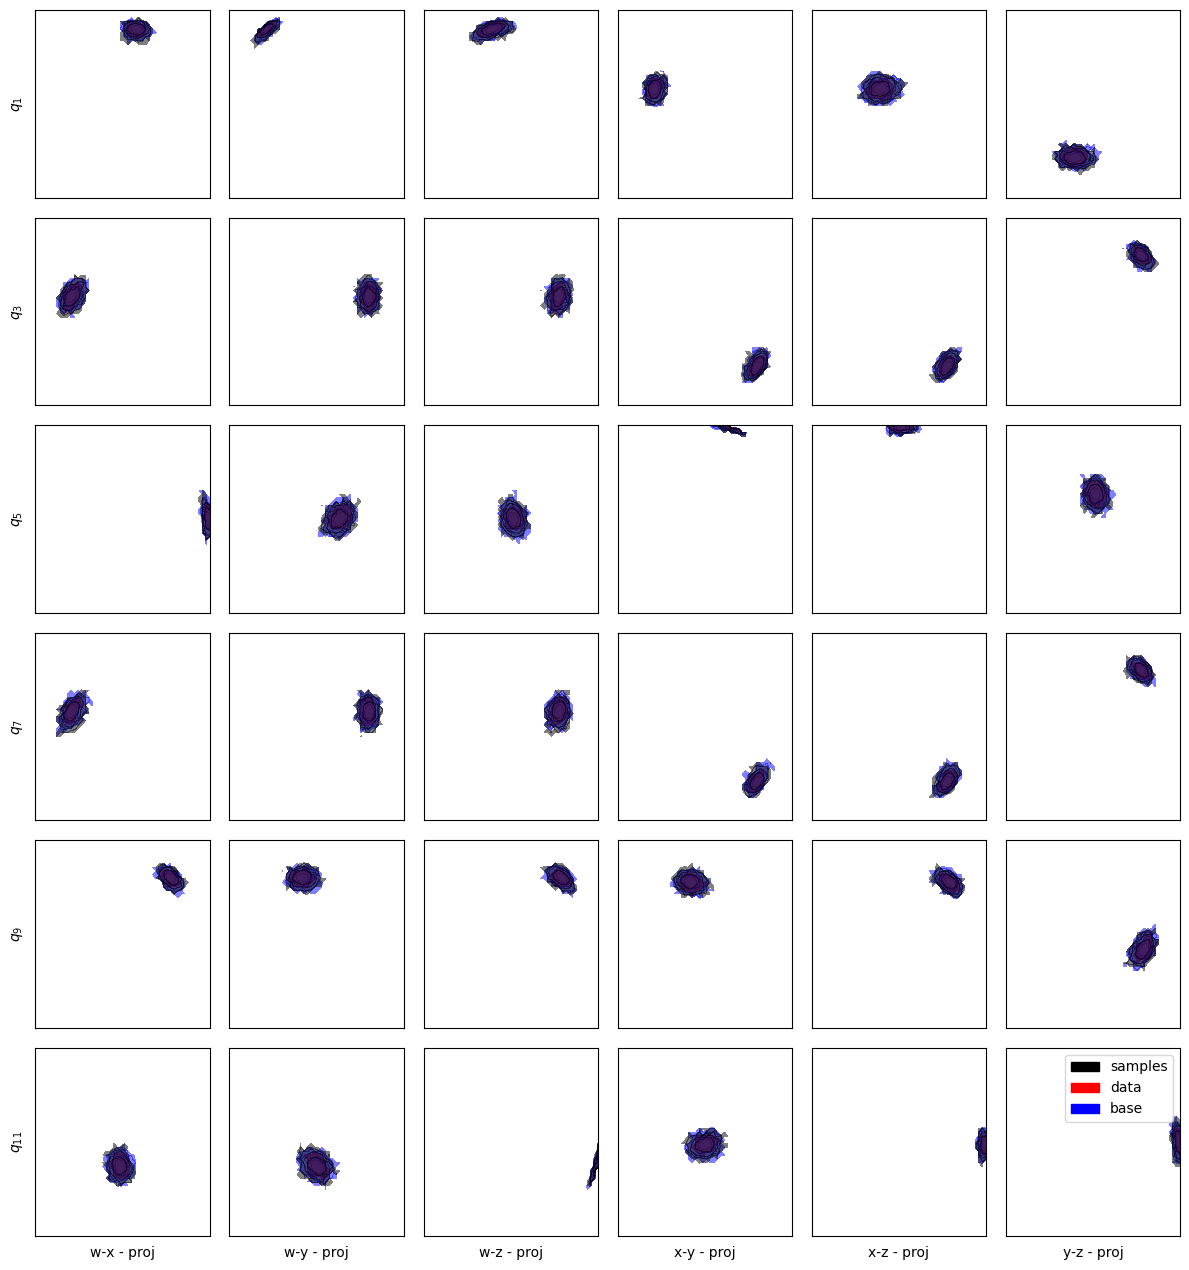

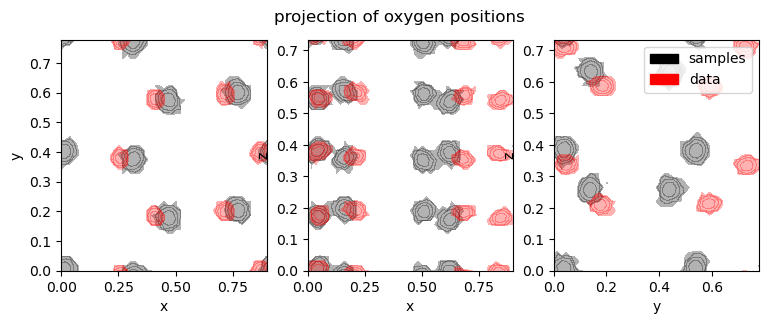

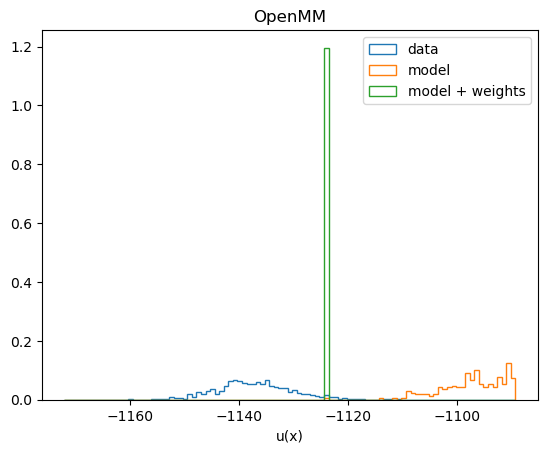

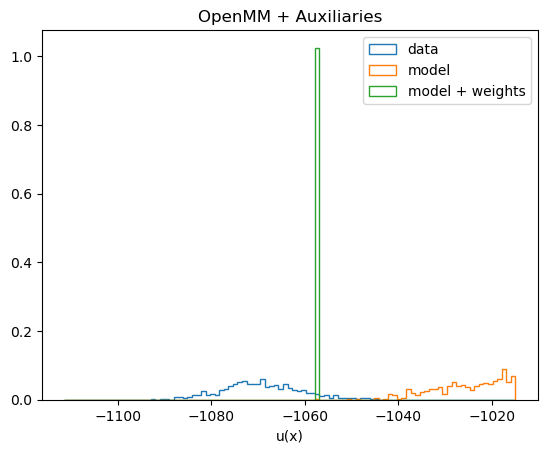

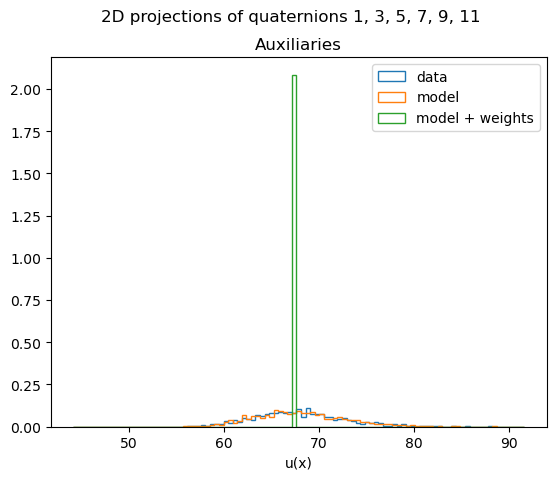

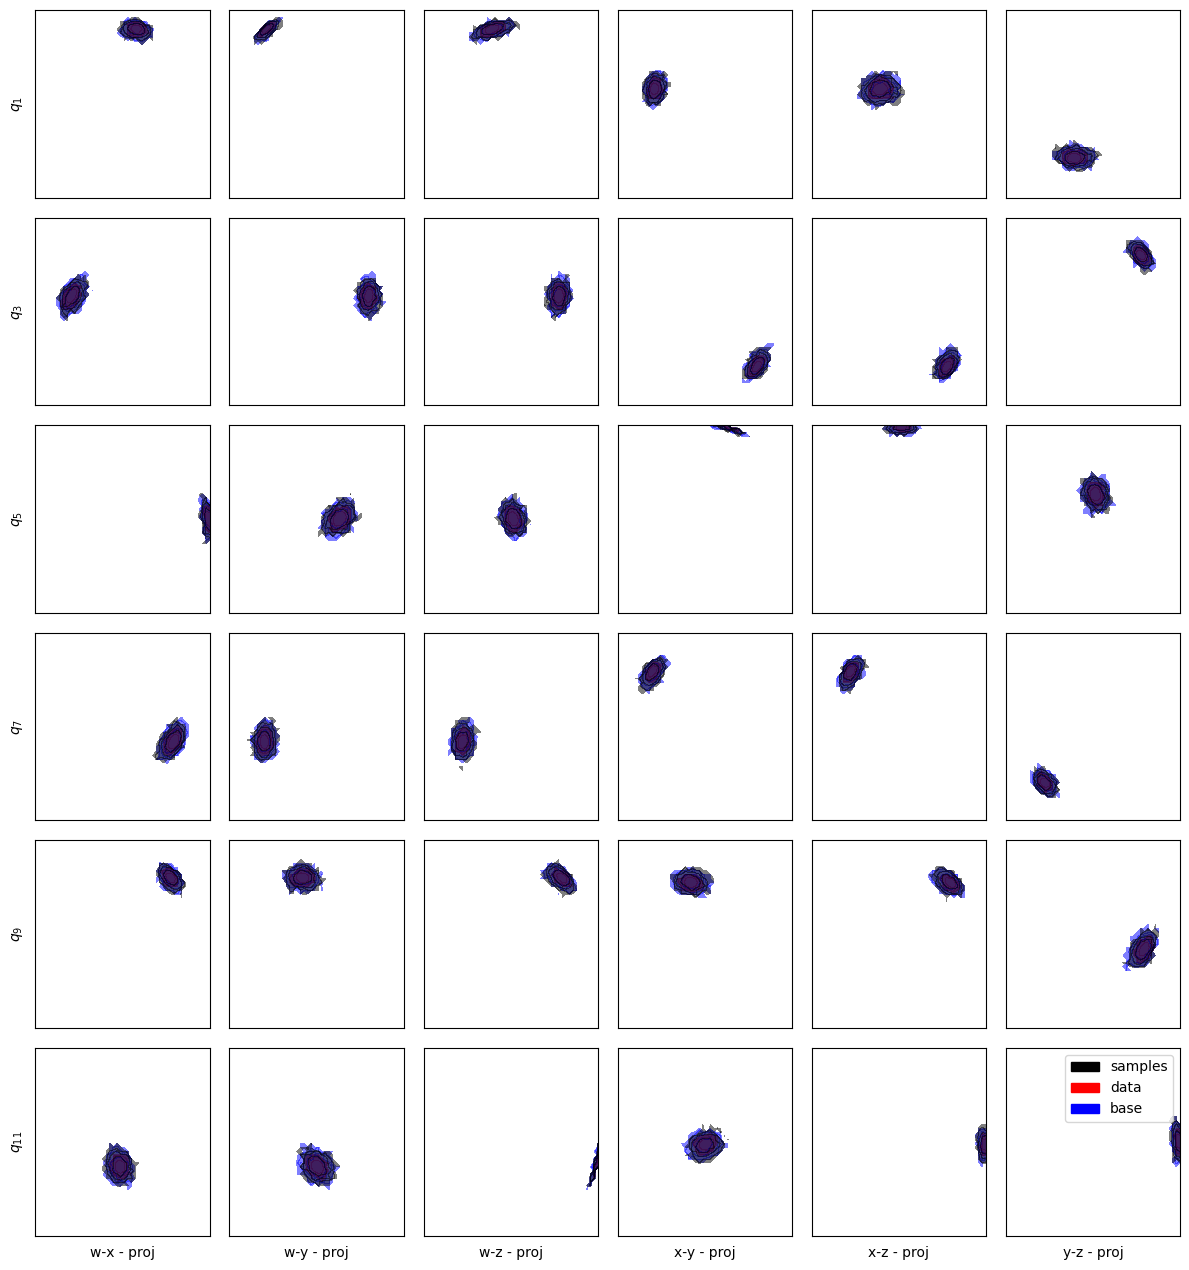

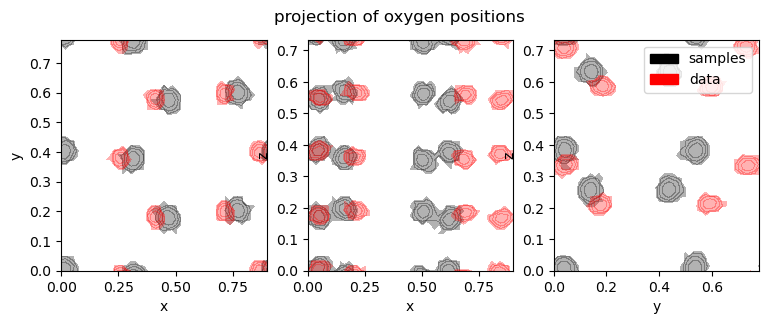

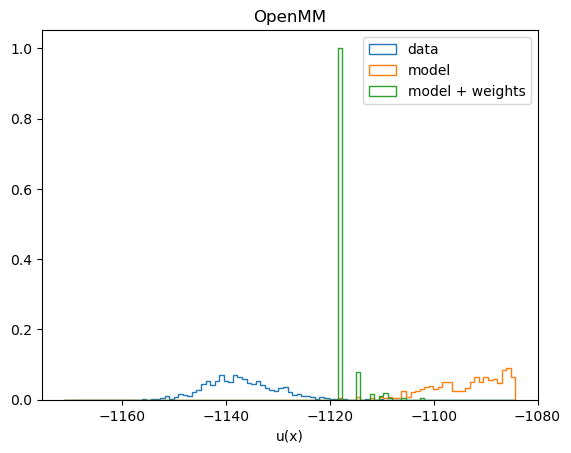

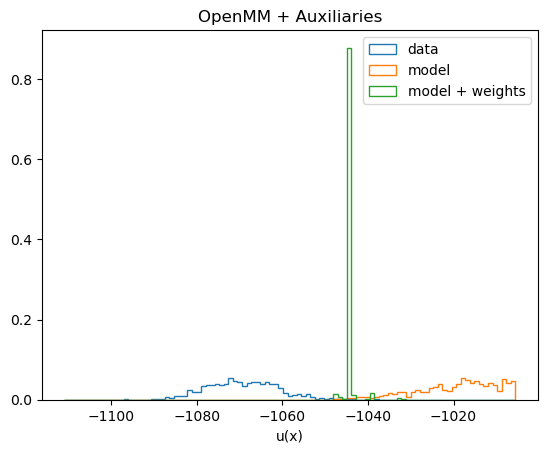

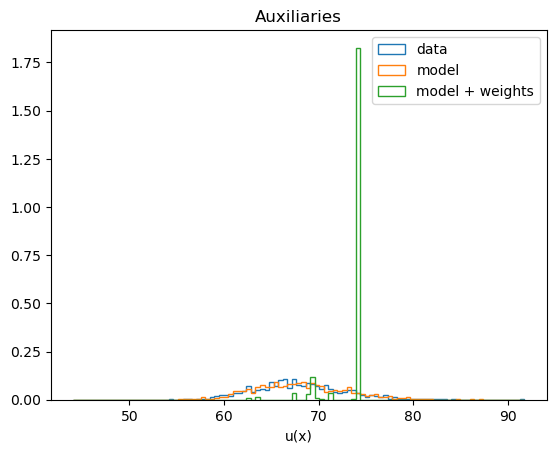

In [17]:
loss_reporter = []
flow = train(next(chain), "testing", specs, base, target, flow, tot_iter, loss_reporter)


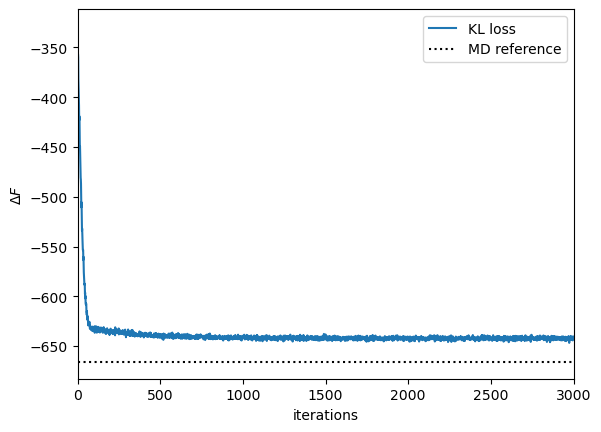

In [18]:
plt.plot(loss_reporter, label='KL loss')
plt.axhline(-666, c="k", ls=":", label='MD reference')
plt.xlim(0, len(loss_reporter))
plt.xlabel('iterations')
plt.ylabel('$\Delta F$')
plt.legend()
plt.show()


In [21]:
keys = jax.random.split(next(chain), num_samples)
bg_obj = jax.vmap(PullbackSampler(base.sample, flow))(keys).obj
bg_k_oxy = jax.vmap(to_rigid)(bg_obj.pos[:, k]).obj
unsigned_bg = normalize_quats(bg_k_oxy.rot, bg_k_oxy.rot[0])


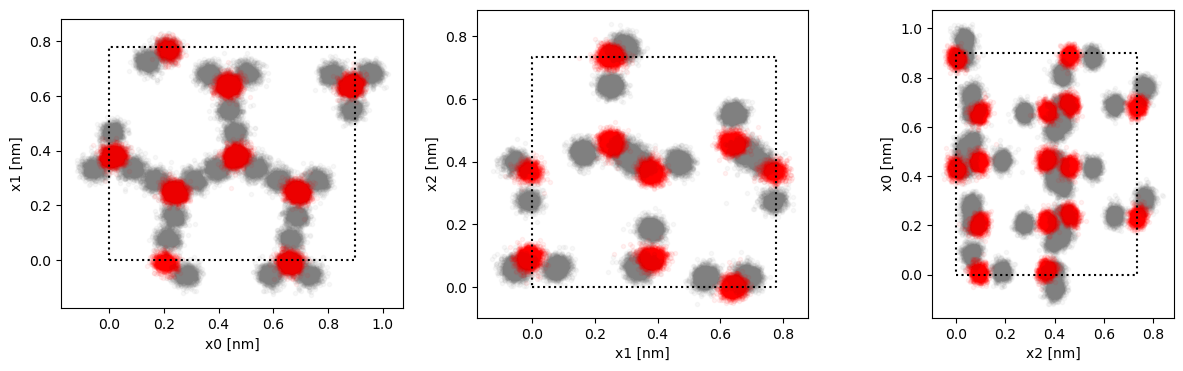

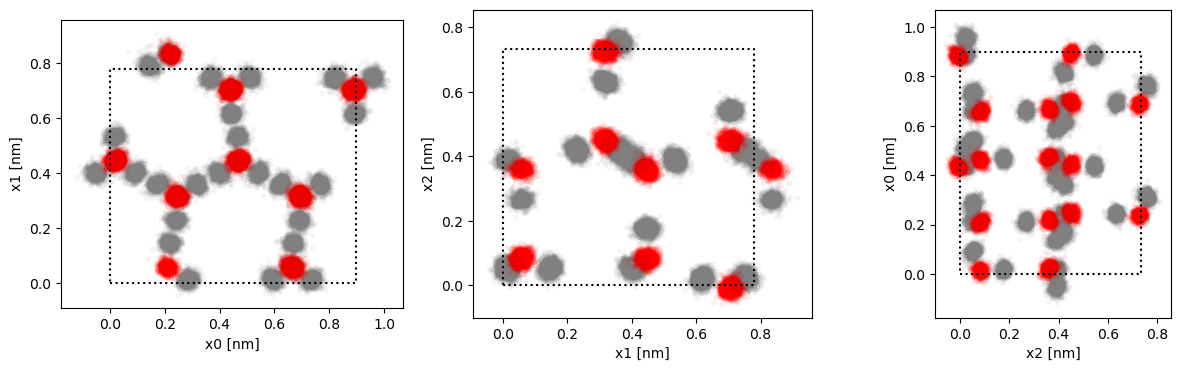

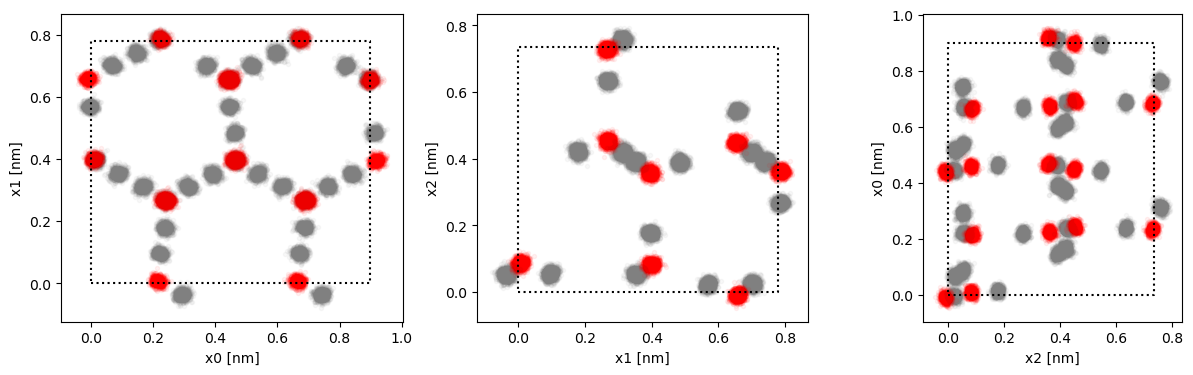

In [33]:
model.plot_2Dview(base_obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(bg_obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(target_obj.pos.reshape(-1, model.n_atoms, 3))


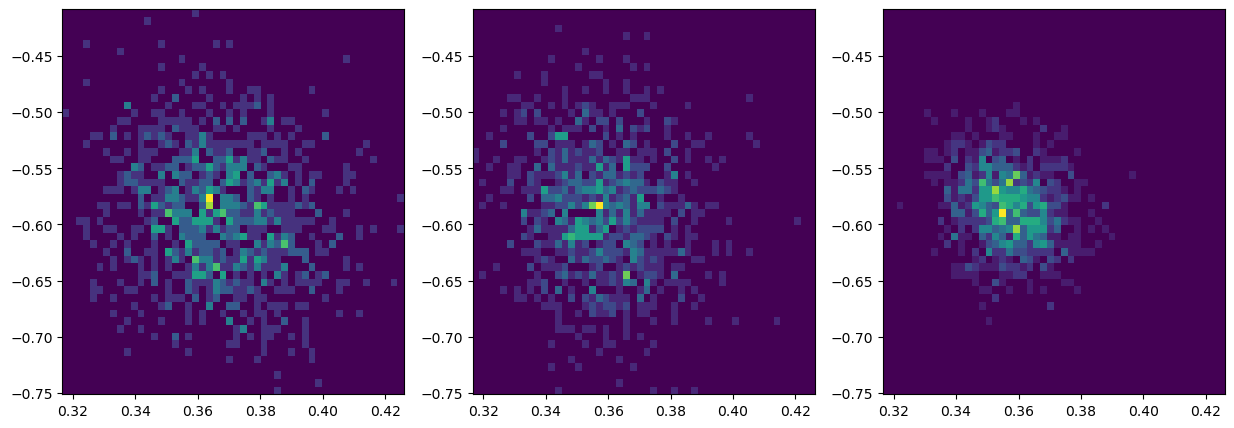

In [23]:
i = 2
j = 3
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
_, xbins, ybins, _ = plt.hist2d(base_k_oxy.pos[:, i], unsigned_base[:, j], bins=50)
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.subplot(1, 3, 2)
plt.hist2d(bg_k_oxy.pos[:, i], unsigned_bg[:, j], bins=(xbins, ybins))
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.subplot(1, 3, 3)
plt.hist2d(target_k_oxy.pos[:, i], unsigned_target[:, j], bins=(xbins, ybins))
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.show()


In [28]:
ene_fn = jax.vmap(target.potential)
base_ene = ene_fn(base_obj)
bg_ene = ene_fn(bg_obj)
target_ene = ene_fn(target_obj)

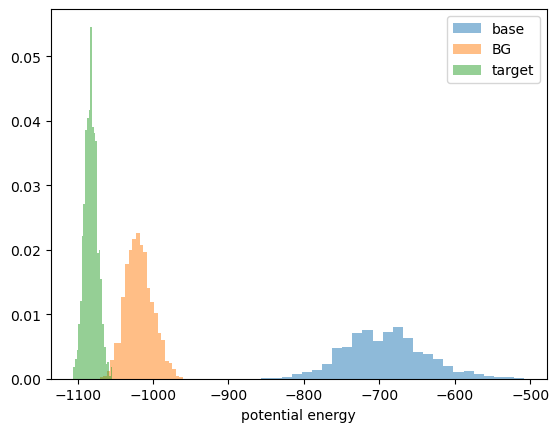

In [31]:
plt.hist(base_ene, **hist_kwargs, label='base')
plt.hist(bg_ene, **hist_kwargs, label='BG')
plt.hist(target_ene, **hist_kwargs, label='target')
plt.xlabel('potential energy')
plt.legend()
plt.show()